In [1]:
#Import standard packages for model training

import tensorflow as T
from tensorflow import *
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import *
import numpy as np
import pandas as pd
import sklearn.metrics as SK
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import io

from utils.GPU import *
from utils import utils

commons = utils.Commons()
ts_helper = utils.TS_Helper()
ts_helper.model_type = ts_helper.Regression
shap_helper = utils.Shap_Helper() 
   
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

  tensorlayer: GPU MEM Fraction 0.900000
Num GPUs Available:  0


In [2]:
#Inport train, validation and test sets

training = './data/Regression/T.cruzi/random_split/train_fold_0.csv'
validation = './data/Regression/T.cruzi/random_split/valid_fold_0.csv'
test = './data/Regression/T.cruzi/random_split/test_fold_0.csv'
TASK_START = 2
NUM_TASKS = 1
SMILES = "SMILES"
train_dataset,y_train,train_smiles = commons.load_dataset(training,SMILES,TASK_START,NUM_TASKS)
val_dataset,y_val,val_smiles = commons.load_dataset(validation,SMILES,TASK_START,NUM_TASKS)
test_dataset,y_test,test_smiles = commons.load_dataset(test,SMILES,TASK_START,NUM_TASKS)
train_dataset.head()

Loaded dataset ./data/Regression/T.cruzi/random_split/train_fold_0.csv with shape: (1465, 3)
Loaded dataset ./data/Regression/T.cruzi/random_split/valid_fold_0.csv with shape: (184, 3)
Loaded dataset ./data/Regression/T.cruzi/random_split/test_fold_0.csv with shape: (183, 3)


,ID,SMILES,Tb_cruzi
0,1484,N1C2C=CC=CC=2C(CCOC2N=CC=NC=2C2C=CN=CC=2)=C1,6.850012
1,304,N(CCC1N=C(C2C=CC=C(F)C=2)SC=1)C(C(C)(C)C)=O,6.149354
2,650,N(S(C1SC(C2C=C(CN(CC3C=CN=CC=3)C)C=CC=2OC)=CC=...,6.299998
3,1096,C1C2OCOC=2C=C(C(CSC2N=C(C)C=C(C)C=2C#N)=O)C=1,5.700001
4,1482,OC(C1C=CC(OC(C)C)=C(F)C=1)(C1C=CC=C(C(N)=O)C=1...,7.004365


In [3]:
#Import atom and bond featurizers

from utils.graphs import *

#Gennerate graphs from SMILES

X_train = graphs_from_smiles(train_dataset.iloc[:,NUM_TASKS].values)

X_test = graphs_from_smiles(test_dataset.iloc[:,NUM_TASKS].values)

X_val = graphs_from_smiles(val_dataset.iloc[:,NUM_TASKS].values)

#Test graph function

# molecule = molecule_from_smiles(train_dataset.iloc[8].SMILES)
# molecules_graph = [molecule_from_smiles(smile) for smile in train_dataset.SMILES]
# graph = [graph_from_molecule(mol) for mol in molecules_graph]
# #graph = graph_from_molecule(molecule)
# print("Graph (including self-loops):")
# print("\tatom features\t", graph[0][0].shape)
# print("\tbond features\t", graph[0][1].shape)
# print("\tpair indices\t", graph[0][2].shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atom_features (InputLayer)     [(None, 29)]         0           []                               
                                                                                                  
 bond_features (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 pair_indices (InputLayer)      [(None, 2)]          0           []                               
                                                                                                  
 message_passing (MessagePassin  (None, 32)          14528       ['atom_features[0][0]',          
 g)                                                               'bond_features[0][0]',      

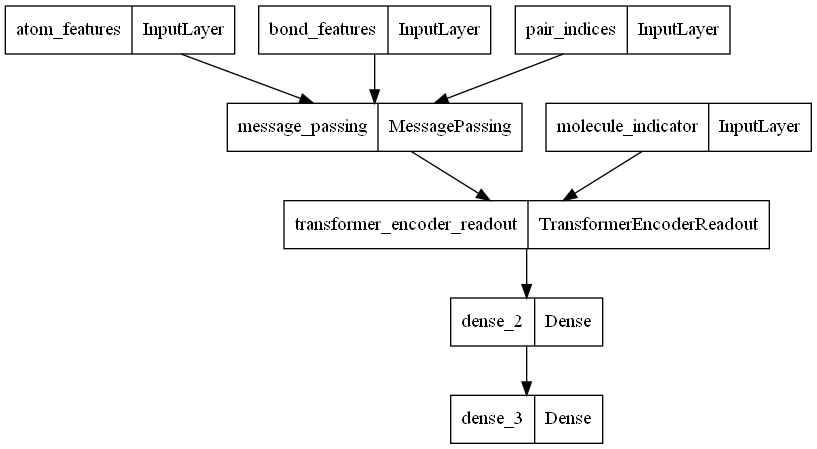

In [4]:
# Import parameters for batch, MPNN, loss and scorers

batch_size = 48
dense_units = 50

from utils.batch import *
from utils.MPNN import *
from utils.utils import *


# parameters for train network

def MPNNModel(atom_dim,
    bond_dim,
    batch_size=batch_size,
    message_units=32,
    message_steps=8,
    num_attention_heads=16,
    dense_units=dense_units):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)([atom_features, bond_features, pair_indices])
    x = TransformerEncoderReadout(num_attention_heads, message_units, dense_units, batch_size)([x, molecule_indicator])
    x = layers.Dense(50, activation="relu")(x)
    x = layers.Dense(NUM_TASKS, activation="linear")(x)
    
    model = keras.Model(inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x])
    return model
    


optimizer = RMSprop(0.1)
lr_metric = ts_helper.get_lr_metric(optimizer)   

model = MPNNModel(atom_dim = X_train[0][0][0].shape[0], bond_dim = X_train[1][0][0].shape[0])
model.compile(loss = ts_helper.regression_loss, metrics = [lr_metric])    
model.summary()
T.keras.utils.plot_model(model)

In [5]:
# Early stopping parameters

train_dataset = MPNNDataset(X_train, y_train, batch_size)
val_dataset = MPNNDataset(X_val, y_val, batch_size)
test_dataset = MPNNDataset(X_test, y_test, batch_size)

callbacks_list = [
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000001, verbose=1, mode='auto',cooldown=0),
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', verbose=1)]

# parameters for train network

epochs=15

history = model.fit(train_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_dataset,                    
                    callbacks=(callbacks_list))

model.save_weights("./models/TM-MPNN_regression_model.hdf5")

Epoch 1/15


c:\Users\Laplace\anaconda3\envs\AI\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/transformer_encoder_readout/partition_padding/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/transformer_encoder_readout/partition_padding/Reshape:0", shape=(None, None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model/transformer_encoder_readout/partition_padding/Cast:0", shape=(3,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\Laplace\anaconda3\envs\AI\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/message_passing/edge_network/Reshape_5:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/message_passing/edge_network/Reshape_4:0", shape=(None,

31/31 [==============================] - 10s 175ms/step - loss: 2.7338 - lr: 0.0010 - val_loss: 1.1949 - val_lr: 0.1000
Epoch 2/15
31/31 [==============================] - 4s 137ms/step - loss: 1.2199 - lr: 0.0010 - val_loss: 1.1564 - val_lr: 0.1000
Epoch 3/15
31/31 [==============================] - 4s 139ms/step - loss: 1.1330 - lr: 0.0010 - val_loss: 1.0413 - val_lr: 0.1000
Epoch 4/15
31/31 [==============================] - 4s 139ms/step - loss: 1.0911 - lr: 0.0010 - val_loss: 0.9703 - val_lr: 0.1000
Epoch 5/15
31/31 [==============================] - 4s 134ms/step - loss: 1.0143 - lr: 0.0010 - val_loss: 0.8668 - val_lr: 0.1000
Epoch 6/15
31/31 [==============================] - 4s 134ms/step - loss: 0.9345 - lr: 0.0010 - val_loss: 0.8088 - val_lr: 0.1000
Epoch 7/15
31/31 [==============================] - 5s 147ms/step - loss: 0.8832 - lr: 0.0010 - val_loss: 0.7945 - val_lr: 0.1000
Epoch 8/15
31/31 [==============================] - 4s 138ms/step - loss: 0.8405 - lr: 0.0010 - val_

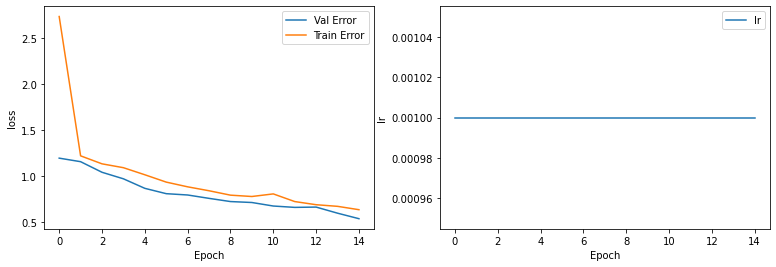

Metric for a Regression Model
4/4 [==============================] - 0s 64ms/step
For Training in task 0 
 Statistic       Value
-----------  --------
MSE          0.552585
MAE          0.561309
R2           0.505999
For Validation in task 0 
 Statistic       Value
-----------  --------
MSE          0.536949
MAE          0.567569
R2           0.54161
For Testing in task 0 
 Statistic       Value
-----------  --------
MSE          0.507639
MAE          0.530828
R2           0.555001


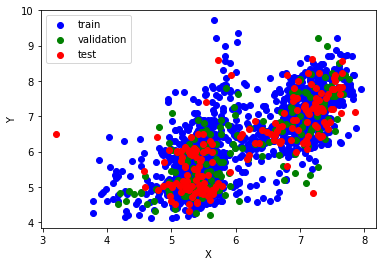

In [6]:
#Plot model history

ts_helper.plot_history(history)

ts_helper.get_modelStats(model,train_dataset,y_train,test_dataset,y_test,val_dataset,y_val,NUM_TASKS)

4/4 [==============================] - 0s 62ms/step
Results for task 1 (train)
r^2	0.74
rmse	0.74
mse	0.55
mae	0.56
Results for task 1 (validation)
r^2	0.75
rmse	0.73
mse	0.54
mae	0.57
Results for task 1 (test)
r^2	0.76
rmse	0.71
mse	0.51
mae	0.53


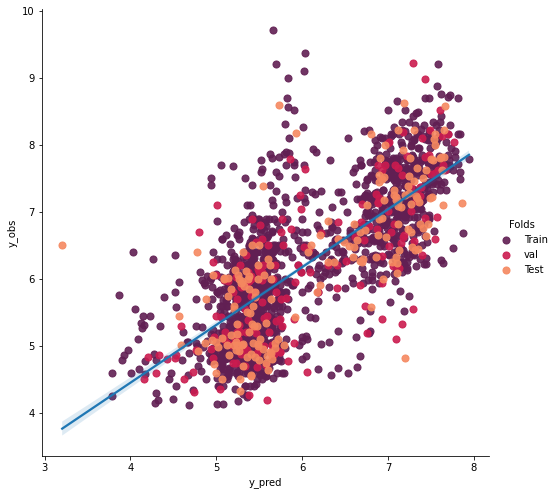

In [7]:
#Statistical characteristico of model without 3-sigma rule

prediction_train = model.predict(train_dataset)
prediction_val = model.predict(val_dataset)
prediction_test = model.predict(test_dataset)


for index1 in range(prediction_train.shape[1]):

    train_pred = pd.DataFrame(y_train[:,index1],prediction_train[:,index1]) 
    train_pred['y_pred'] = train_pred.index
    train_pred = train_pred.rename(columns = {0: 'y_obs'})
    train_pred2 = train_pred.dropna()
    train_pred2 = train_pred2.reset_index(drop=True)
    train_pred2['Folds'] = 'Train'
    train_pred2 = train_pred2.assign(Folds_error = abs(train_pred2['y_pred'] - train_pred2['y_obs']))
    train_pred2['Folds error Mean'] = train_pred2['Folds_error'].mean() 
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds_error'].std()
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds error 3*sigma']*3

    for index2 in range(prediction_val.shape[1]):
         
        val_pred = pd.DataFrame(y_val[:,index2],prediction_val[:,index2])
        val_pred['y_pred'] = val_pred.index
        val_pred = val_pred.rename(columns = {0: 'y_obs'})
        val_pred2 = val_pred.dropna()
        val_pred2 = val_pred2.reset_index(drop=True)
        val_pred2['Folds'] = 'val'
        val_pred2 = val_pred2.assign(Folds_error = abs(val_pred2['y_pred'] - val_pred2['y_obs']))
        val_pred2['Folds error Mean'] = val_pred2['Folds_error'].mean() 
        val_pred2['Folds error 3*sigma'] = val_pred2['Folds_error'].std()
        val_pred2['Folds error 3*sigma'] = val_pred2['Folds error 3*sigma']*3
           
            
        for index3 in range(prediction_test.shape[1]):
         
            test_pred = pd.DataFrame(y_test[:,index3],prediction_test[:,index3])
            test_pred['y_pred'] = test_pred.index
            test_pred = test_pred.rename(columns = {0: 'y_obs'})
            test_pred2 = test_pred.dropna()
            test_pred2 = test_pred2.reset_index(drop=True)
            test_pred2['Folds'] = 'Test'
            test_pred2 = test_pred2.assign(Folds_error = abs(test_pred2['y_pred'] - test_pred2['y_obs']))
            test_pred2['Folds error Mean'] = test_pred2['Folds_error'].mean() 
            test_pred2['Folds error 3*sigma'] = test_pred2['Folds_error'].std()
            test_pred2['Folds error 3*sigma'] = test_pred2['Folds error 3*sigma']*3

            crossval_df = pd.concat([train_pred2, val_pred2, test_pred2], axis=0).reset_index(drop=True)


            if index1 == index2 and index1 == index3:
                    
                r2  = (train_pred2["y_obs"].corr(train_pred2["y_pred"]))    
                print(("Results for task {} (train)").format(index2+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f" % sqrt(mean_squared_error(train_pred2["y_obs"],train_pred2["y_pred"])))
                print ("mse\t%.2f" % (mean_squared_error(train_pred2["y_obs"],train_pred2["y_pred"])))
                print ("mae\t%.2f"  %mean_absolute_error(train_pred2["y_obs"],train_pred2["y_pred"]))   

                r2 = (val_pred2["y_obs"].corr(val_pred2["y_pred"]))
                print(("Results for task {} (validation)").format(index3+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f"  % sqrt(mean_squared_error(val_pred2["y_pred"],val_pred2["y_obs"])))
                print ("mse\t%.2f"  % (mean_squared_error(val_pred2["y_pred"],val_pred2["y_obs"])))
                print ("mae\t%.2f"  % mean_absolute_error(val_pred2["y_pred"],val_pred2["y_obs"]))
                
                r2 = (test_pred2["y_obs"].corr(test_pred2["y_pred"])) 
                print(("Results for task {} (test)").format(index1+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f"  % sqrt(mean_squared_error(test_pred2["y_pred"],test_pred2["y_obs"]))) 
                print ("mse\t%.2f"  % (mean_squared_error(test_pred2["y_pred"],test_pred2["y_obs"])))
                print ("mae\t%.2f"  % mean_absolute_error(test_pred2["y_pred"],test_pred2["y_obs"]))

                g = sns.lmplot(x="y_pred", y="y_obs", hue="Folds", data=crossval_df, fit_reg=False, height=7, 
                markers=["o", "o", "o"], palette="rocket",scatter_kws={"s": 50,'alpha':0.9},  aspect=30/30)
                sns.regplot(x="y_pred", y="y_obs", data=crossval_df, scatter=False, ax=g.axes[0, 0]) 

Results for task 1 (train)
r^2	0.82
rmse	0.60
mse	0.37
mae	0.49
Results for task 1 (validation)
r^2	0.84
rmse	0.58
mse	0.33
mae	0.47
Results for task 1 (test)
r^2	0.84
rmse	0.56
mse	0.31
mae	0.46


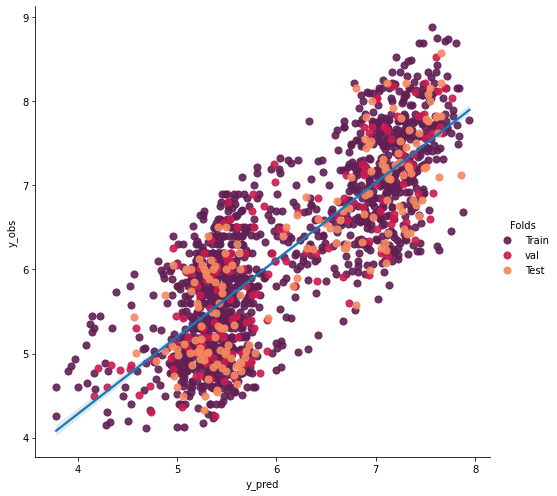

In [8]:
#Statistical characteristico of model using 3-sigma rule

for index1 in range(prediction_train.shape[1]):

    train_pred = pd.DataFrame(y_train[:,index1],prediction_train[:,index1]) 
    train_pred['y_pred'] = train_pred.index
    train_pred = train_pred.rename(columns = {0: 'y_obs'})
    train_pred2 = train_pred.dropna()
    train_pred2 = train_pred2.reset_index(drop=True)
    train_pred2['Folds'] = 'Train'
    train_pred2 = train_pred2.assign(Folds_error = abs(train_pred2['y_pred'] - train_pred2['y_obs']))
    train_pred2['Folds error Mean'] = train_pred2['Folds_error'].mean() 
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds_error'].std()
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds error 3*sigma']*3
    train_pred2=train_pred2[train_pred2['Folds_error']<=(train_pred2['Folds error 3*sigma'])] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

    for index2 in range(prediction_val.shape[1]):
         
        val_pred = pd.DataFrame(y_val[:,index2],prediction_val[:,index2])
        val_pred['y_pred'] = val_pred.index
        val_pred = val_pred.rename(columns = {0: 'y_obs'})
        val_pred2 = val_pred.dropna()
        val_pred2 = val_pred2.reset_index(drop=True)
        val_pred2['Folds'] = 'val'
        val_pred2 = val_pred2.assign(Folds_error = abs(val_pred2['y_pred'] - val_pred2['y_obs']))
        val_pred2['Folds error Mean'] = val_pred2['Folds_error'].mean() 
        val_pred2['Folds error 3*sigma'] = val_pred2['Folds_error'].std()
        val_pred2['Folds error 3*sigma'] = val_pred2['Folds error 3*sigma']*3
        val_pred2=val_pred2[val_pred2['Folds_error']<=(val_pred2['Folds error 3*sigma'])]#keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
   
        for index3 in range(prediction_test.shape[1]):

            test_pred = pd.DataFrame(y_test[:,index3],prediction_test[:,index3])
            test_pred['y_pred'] = test_pred.index
            test_pred = test_pred.rename(columns = {0: 'y_obs'})
            test_pred2 = test_pred.dropna()
            test_pred2 = test_pred2.reset_index(drop=True)
            test_pred2['Folds'] = 'Test'
            test_pred2 = test_pred2.assign(Folds_error = abs(test_pred2['y_pred'] - test_pred2['y_obs']))
            test_pred2['Folds error Mean'] = test_pred2['Folds_error'].mean() 
            test_pred2['Folds error 3*sigma'] = test_pred2['Folds_error'].std()
            test_pred2['Folds error 3*sigma'] = test_pred2['Folds error 3*sigma']*3
            test_pred2=test_pred2[test_pred2['Folds_error']<=(test_pred2['Folds error 3*sigma'])] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

            crossval_df = pd.concat([train_pred2, val_pred2, test_pred2], axis=0).reset_index(drop=True)

            if index1 == index2 and index1 == index3:
                        
                r2 = (train_pred2["y_obs"].corr(train_pred2["y_pred"]))    
                print(("Results for task {} (train)").format(index2+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f" % sqrt(mean_squared_error(train_pred2["y_obs"],train_pred2["y_pred"])))
                print ("mse\t%.2f" % (mean_squared_error(train_pred2["y_obs"],train_pred2["y_pred"])))
                print ("mae\t%.2f"  %mean_absolute_error(train_pred2["y_obs"],train_pred2["y_pred"]))   

                r2= (val_pred2["y_obs"].corr(val_pred2["y_pred"]))
                print(("Results for task {} (validation)").format(index3+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f"  % sqrt(mean_squared_error(val_pred2["y_pred"],val_pred2["y_obs"])))
                print ("mse\t%.2f"  % (mean_squared_error(val_pred2["y_pred"],val_pred2["y_obs"])))
                print ("mae\t%.2f"  % mean_absolute_error(val_pred2["y_pred"],val_pred2["y_obs"]))
                
                r2 = (test_pred2["y_obs"].corr(test_pred2["y_pred"])) 
                print(("Results for task {} (test)").format(index1+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f"  % sqrt(mean_squared_error(test_pred2["y_pred"],test_pred2["y_obs"]))) 
                print ("mse\t%.2f"  % (mean_squared_error(test_pred2["y_pred"],test_pred2["y_obs"])))
                print ("mae\t%.2f"  % mean_absolute_error(test_pred2["y_pred"],test_pred2["y_obs"]))

                g = sns.lmplot(x="y_pred", y="y_obs", hue="Folds", data=crossval_df, fit_reg=False, height=7, 
                markers=["o", "o", "o"], palette="rocket",scatter_kws={"s": 50,'alpha':0.9},  aspect=30/30)
                sns.regplot(x="y_pred", y="y_obs", data=crossval_df, scatter=False, ax=g.axes[0, 0]) 